# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [10]:
negative = correlations < 0

correlations.plot(kind='barh', 
                  color=negative.map({True:'red',False:'blue'}),
                 figsize=(18,15),xlim=(-1,1))

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
#survey_fields

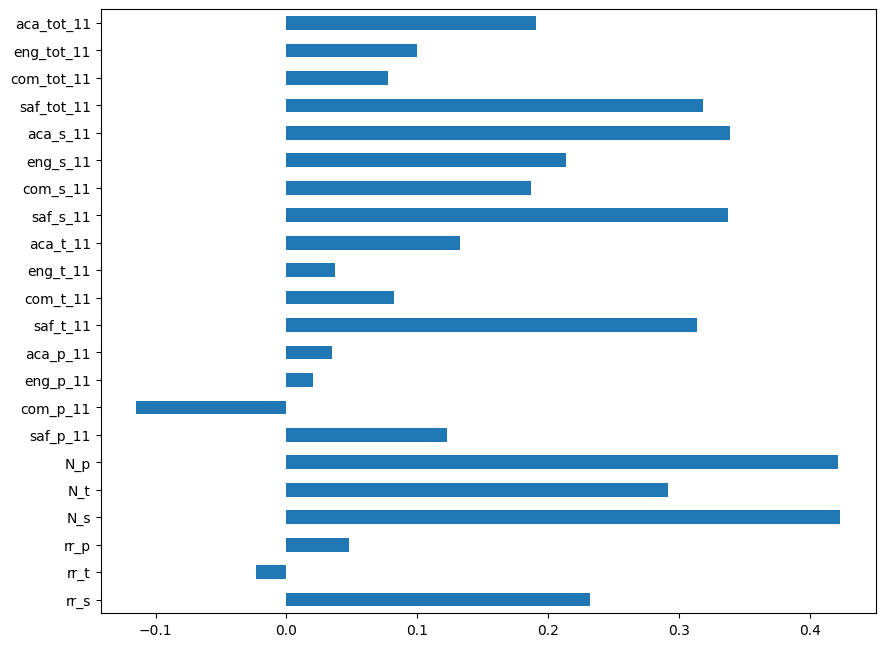

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

correlations[survey_fields].plot(kind='barh',figsize=(10,8))

- N_s, N_t, and N_p have positive relationships with sat_scores 
  - N_s:Number of student respondents
  - N_p:Number of parents respondents
  - N_t:Number of teacher respondents

<p></p>

- The safety and respect score has positive relationship with sat_score according to the parameter saf_t_11, saf_s_11, and saf_total_11.

<p></p>

- aca_s_11 represents the Academic expectations scores based on teachers responses, which has a positive relationship with sat_scores.

<p></p>

<h2>Safety score and sat_score</h2>

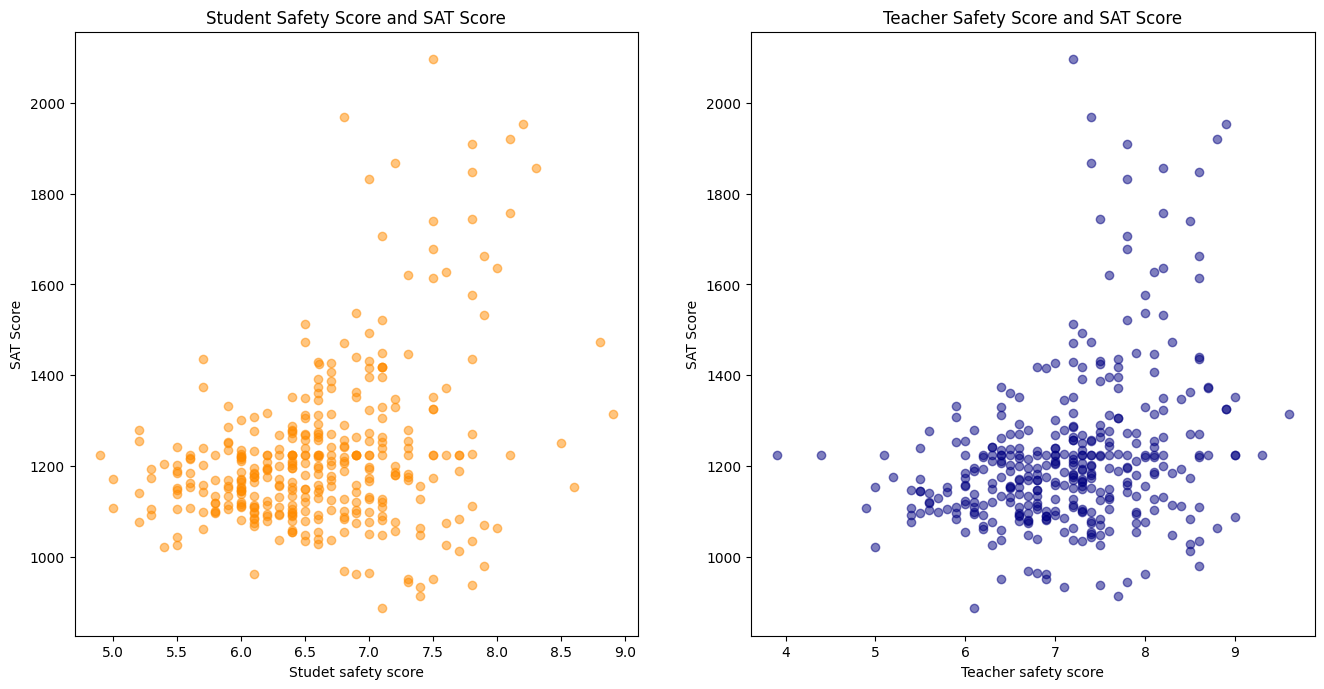

In [33]:
saf_sat = plt.figure(figsize=(16,8))
saf_s = saf_sat.add_subplot(121)
saf_t = saf_sat.add_subplot(122)

saf_s.scatter(x=combined['saf_s_11'], y = combined['sat_score'], 
                     color='darkorange',alpha=0.5)
saf_s.set_title('Student Safety Score and SAT Score')
saf_s.set_xlabel('Studet safety score')
saf_s.set_ylabel('SAT Score')

saf_t.scatter(x=combined['saf_t_11'], y = combined['sat_score'], 
                     color='navy',alpha=0.5)
saf_t.set_title('Teacher Safety Score and SAT Score')
saf_t.set_xlabel('Teacher safety score')
saf_t.set_ylabel('SAT Score')

plt.show()

According to the scatter plot, we can find that the relationship between saf_s_11/saf_t_11 and sat_score is random. However, some high sat scores are from the schools which have higher safety scores.


<h2>Compute the average safety score</h2>

In [15]:
avg_saf = pd.pivot_table(combined, index='school_dist', values='saf_tot_11',aggfunc=numpy.mean)

avg_saf.sort_values(by='saf_tot_11',ascending =False)


,saf_tot_11
school_dist,
22,7.850000
24,7.753846
04,7.714286
12,7.666667
06,7.660000
20,7.620000
30,7.577778
25,7.525000
02,7.520833


<h2>Race and sat_score </h2>

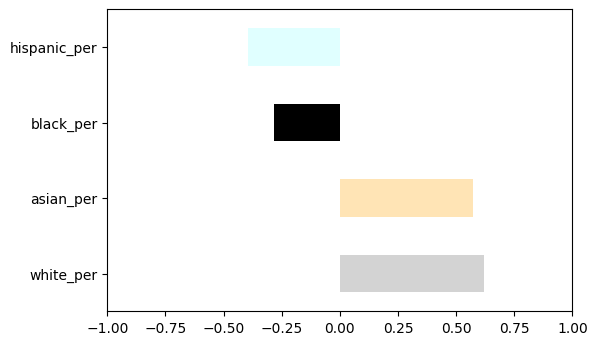

In [35]:
race_cols=['white_per','asian_per','black_per','hispanic_per']

correlations[race_cols].plot(kind='barh', 
                             color=['lightgrey','moccasin','k','lightcyan'],
                            xlim=(-1,1))

Upon the bar chart, it seems that the percentages of white and asian students have positve relationship with sat_score, meaning that these students achieved higher sat scores and increase the schools' sat results. While, the percentage of black and hispanic students have negatove influence on the sat_score, iwhich may indicating that these students didn't get good enough sat scores.

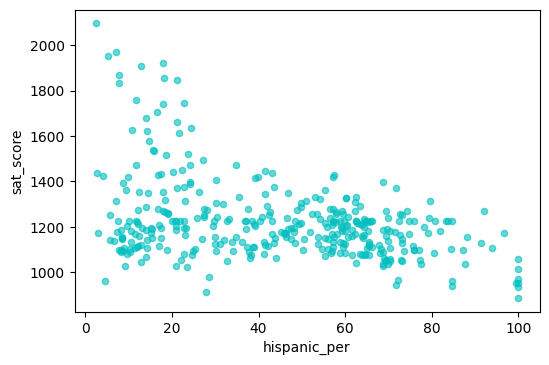

In [17]:
combined.plot.scatter(x='hispanic_per',y='sat_score', 
                      color='c', alpha=0.6)

From the scatter plot, most schools located around sat_score between 1100 and 1400, and most of these schools have different hispanic_per from 20 to 70. However, there are some high sat_score schools did have small hispanic_per.

In [18]:
school_name = combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
school_name

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [19]:
low_hip_hig_sat =combined[combined['hispanic_per']<10]

low_hip_hig_sat = low_hip_hig_sat[low_hip_hig_sat['sat_score'] >1800]

low_hip_hig_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0.0,0.0,0.0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0.0,0.0,0.0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


There are 5 schools whose sat_score higher than 1800 with a less than 10% hispanic.

<h2>Gender and Sat_score</h2>

Investigate the relationship between gender and sat score.

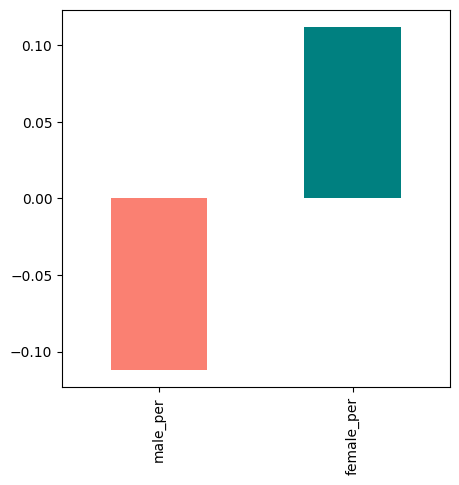

In [20]:
gender_cols=['male_per','female_per']

correlations[gender_cols].plot( kind='bar', color=['salmon','teal'], figsize=(5,5))

As showed in the bar chat, the correlation of male_per and female_per are about -0.12 and +0.12, menaing that the gender percentage has weak relationship with sat_score.

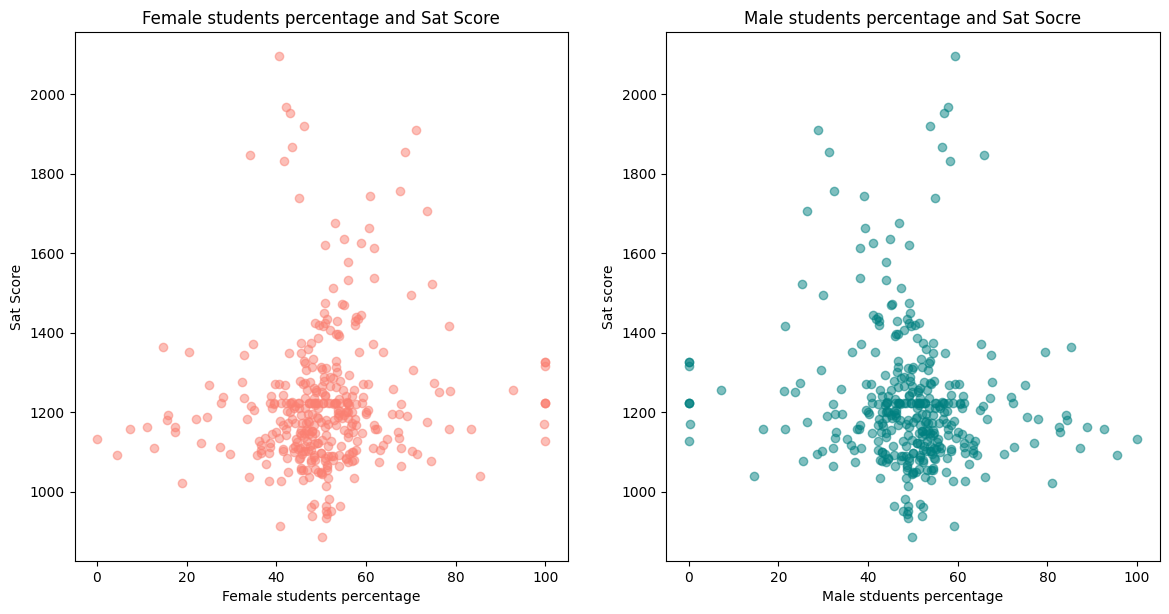

In [21]:
fig = plt.figure(figsize=(14,7))

fig1 = fig.add_subplot(121)
fig2 = fig.add_subplot(122)

fig1.scatter(combined['female_per'], combined['sat_score'], 
             color='salmon', alpha=0.5)
fig1.set_title('Female students percentage and Sat Score')
fig1.set_xlabel('Female students percentage')
fig1.set_ylabel('Sat Score')

fig2.scatter(combined['male_per'], combined['sat_score'],
            color='teal', alpha=0.5)
fig2.set_title('Male students percentage and Sat Socre')
fig2.set_xlabel('Male stduents percentage')
fig2.set_ylabel('Sat score')

plt.show()


<p></p>
Research schools with a female_per greater than 60% and an average SAT score greater than 1700
<p></p>

In [22]:
school_female_great = combined[combined['female_per'] >60]
school_female_great = school_female_great[school_female_great['sat_score']>1700]

school_female_great['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

<h2> Enrolment and Sat Score</h2>

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. 

In [23]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

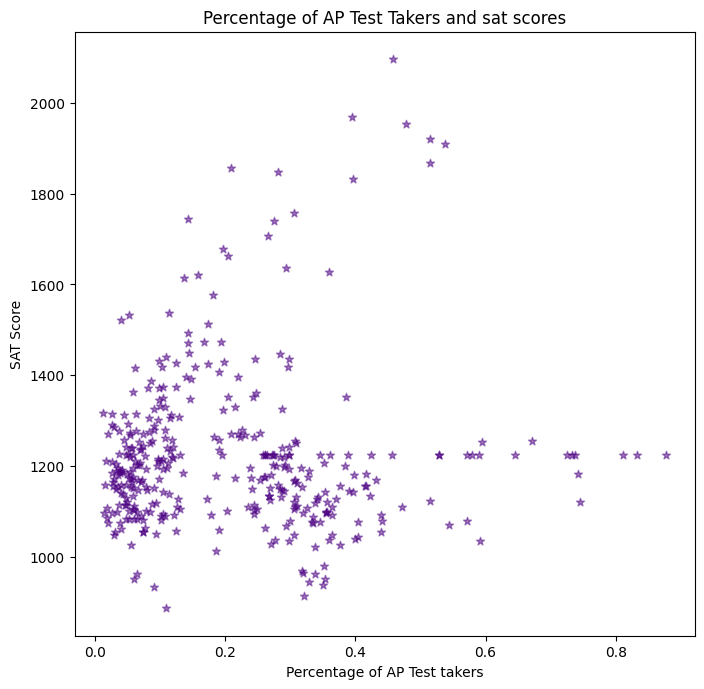

In [24]:
ap_sat = plt.figure(figsize=(8,8))
ap_sat = plt.scatter(combined['ap_per'], combined['sat_score'],
                     color='indigo', marker='*',alpha=0.5)
plt.title('Percentage of AP Test Takers and sat scores')
plt.xlabel('Percentage of AP Test takers')
plt.ylabel('SAT Score')
plt.show()

The ap_per and sat_score have a weak relationship based on the scatter plot. This could be because the larger number of AP test takers means a larger number of students who are comfortable taking standardized academic exams.

<p></p>

Meanwhile, the location that ap_per from 0 to 0.4 and the sat_score between 1000 to 1300 located most schools.

<h2>Class size and SAT score</h2>

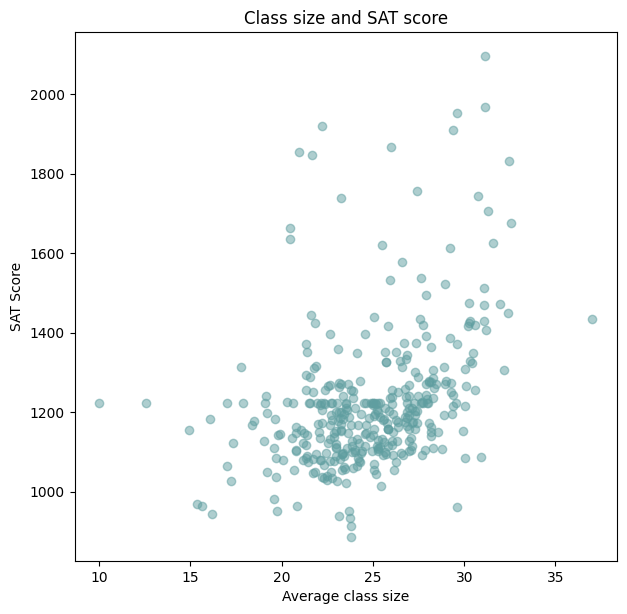

In [25]:
# use the columns : AVERAGE CLASS SIZE

size_sat = plt.figure(figsize=(7,7))
size_sat = plt.scatter(combined['AVERAGE CLASS SIZE'],
                       combined['sat_score'],
                      color ='cadetblue', alpha=0.5)

plt.xlabel('Average class size')
plt.ylabel('SAT Score')
plt.title('Class size and SAT score')
plt.show()

The correlation between class size and sat score is weak.

<h2>District and schools </h2>

This section will list the district with according to schools SAT scores, so people can find a district with good schools. if we can combine it with the property prices of all districts, then people can find the least expensive neighborhoods with good schools and within their budget.
<p></p>

In [48]:
combined[['Location 1','school_dist','lat','lon']]

,Location 1,school_dist,lat,lon
0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",01,40.713764,-73.985260
1,"200 Monroe Street\nNew York, NY 10002\n(40.712...",01,40.712332,-73.984797
2,"420 East 12 Street\nNew York, NY 10009\n(40.72...",01,40.729783,-73.983041
3,"145 Stanton Street\nNew York, NY 10002\n(40.72...",01,40.720569,-73.985673
4,"111 Columbia Street\nNew York, NY 10002\n(40.7...",01,40.718725,-73.979426
...,...,...,...,...
358,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",32,40.694482,-73.929154
359,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",32,40.696962,-73.910816
360,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",32,40.696962,-73.910816
361,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",32,40.697408,-73.913153


#### Calculate the averge sat score for each dist

In [74]:
dist_sat = pd.pivot_table(combined, index='school_dist',
                          values=['sat_score','saf_tot_11'])

# dist_sat.plot(kind='barh',figsize=(10,10), fontsize=8, 
#               title = 'School District and AVG. SAT Score',
#               color='b',
#               legend=False )

dist_sat = dist_sat.reset_index()


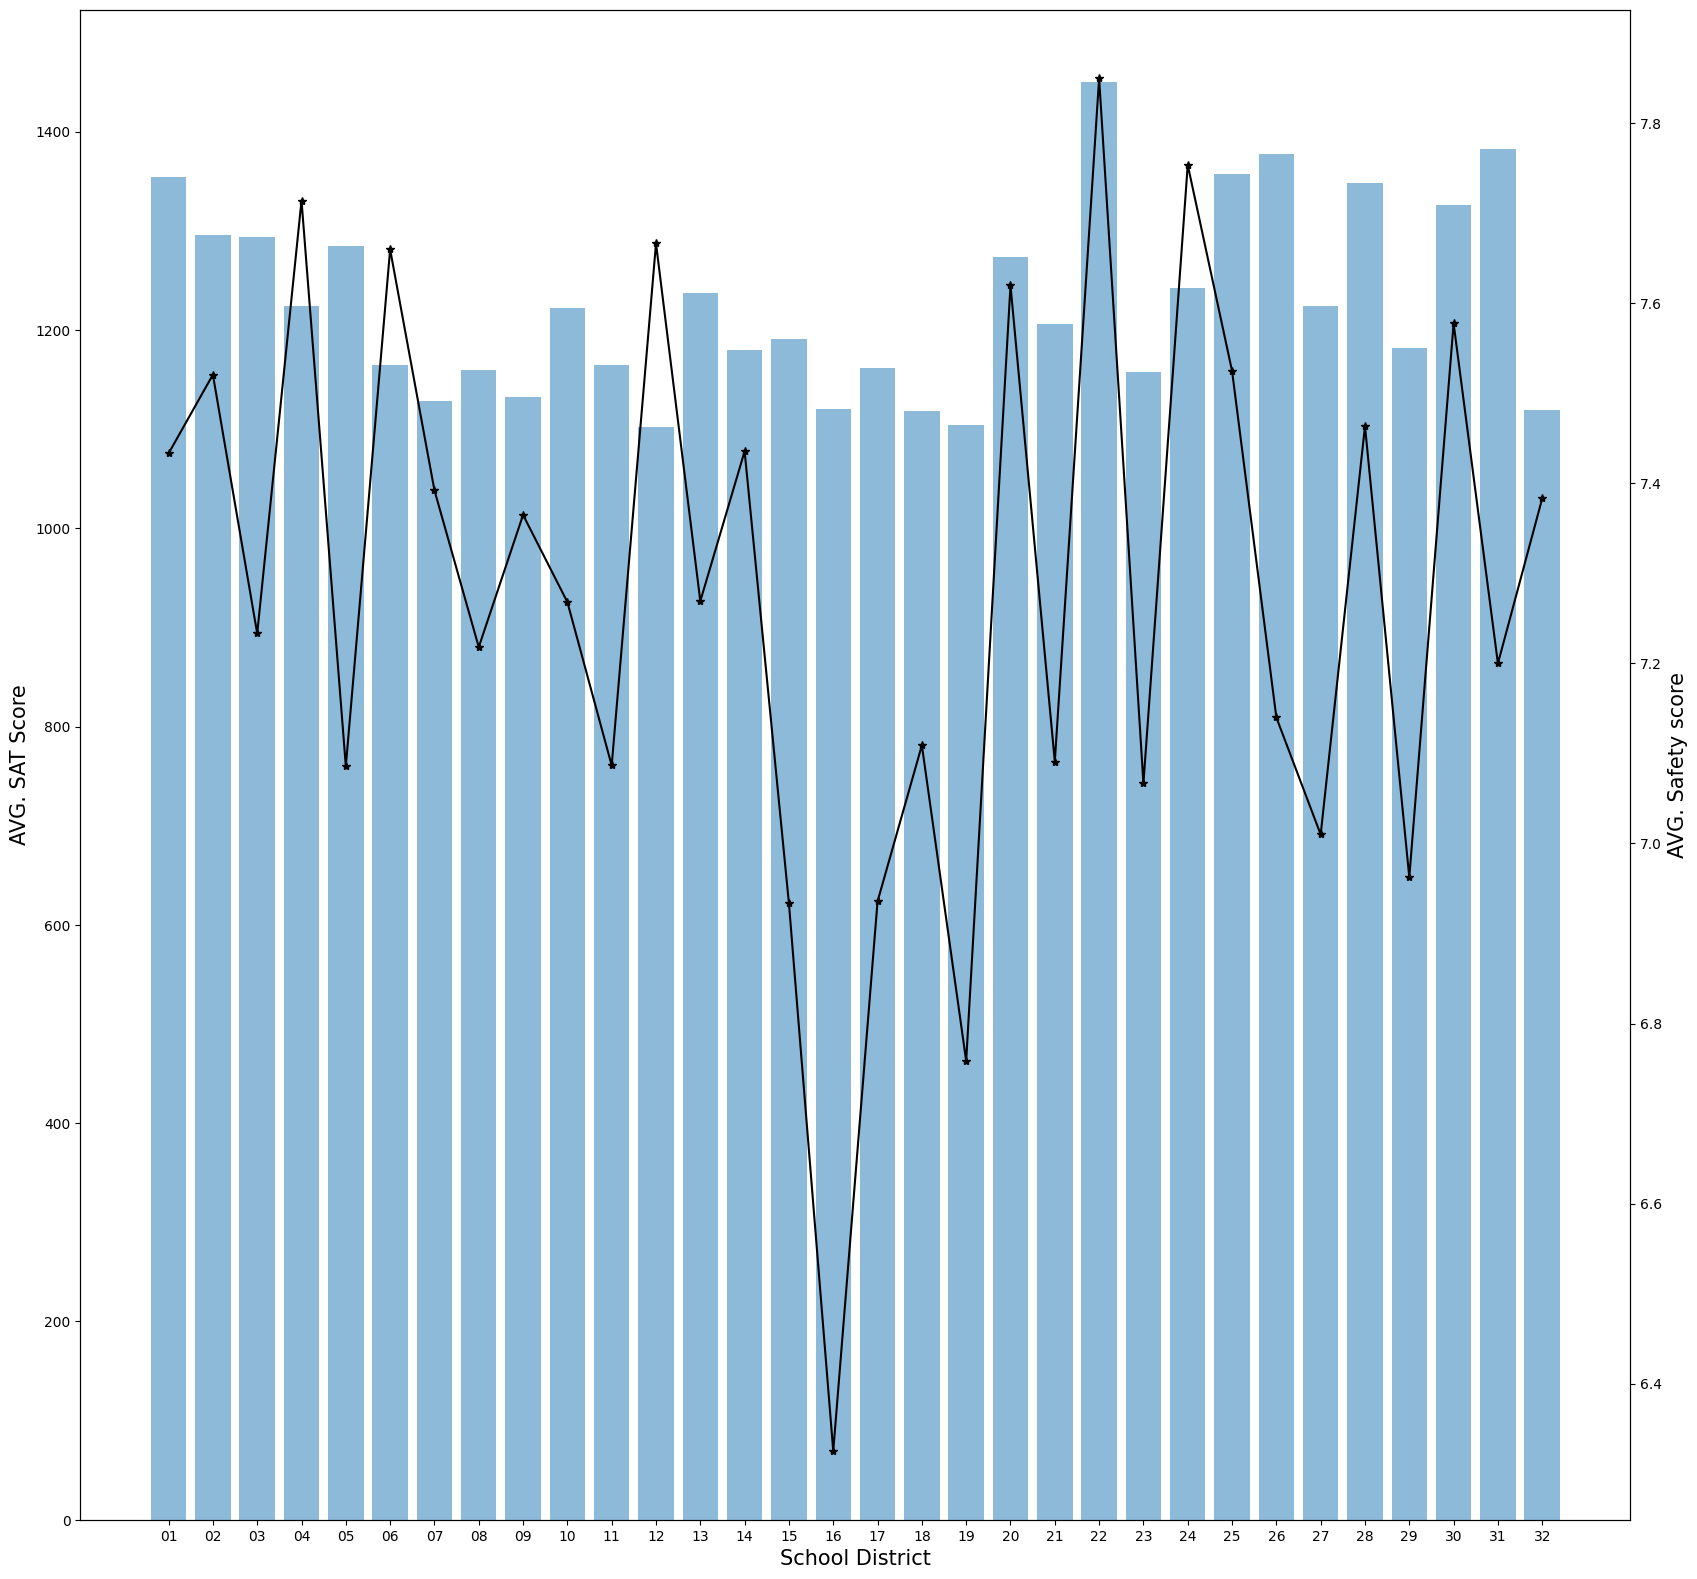

In [92]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(111)
x = dist_sat['school_dist']
y1 = dist_sat['sat_score']
y2 = dist_sat['saf_tot_11']

ax1.bar(x,y1,alpha=0.5)
ax1.set_xlabel('School District',fontsize=15)
ax1.set_ylabel('AVG. SAT Score',fontsize=15)

ax2 = ax1.twinx()
ax2.plot(x,y2,color='k',marker="*")
ax2.set_ylabel('AVG. Safety score',fontsize=15)

plt.show()

Schools located at the districts 01, 22,25,26 and 31 performs better on SAT tests. And schools located in district 01 perform best with highest safety score. Which could be a reference for parents. 

<h2>Conclusion</h2>
<p></p>
As we discussed above, we analyze some elements which could be closely correlated with the sat scores, such as gender, surveys, safety, and race, etc. But most of them actually have weak correlations with sat score. 

However, some good schools with highest sat scores did have high safety score, or low percentage of hispanic and black students.